# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [20]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [177]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [179]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [236]:
#your turn
#merge datasets
df = pd.merge(df_offers, df_transactions)
#create customer X offer table of 0s and 1s
df_01 = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
# convert NaNs to 0
df_01 = df_01.fillna(0).reset_index()
#Grab 0/1 columns for use later
cols_01 = df_01.columns[1:]
df_01.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

__In a very general sense, lower values of SS represent better clusterings because that means there is reduced error. However, lower is not always better, as SS will always decrease with higher k, up to the point where k = the number of datapoints and SS = 0. What is more important is the _rate_ at which SS decreases. That is why we try to look for the elbow in the plot which signifies a significant reduction in rate.__ 

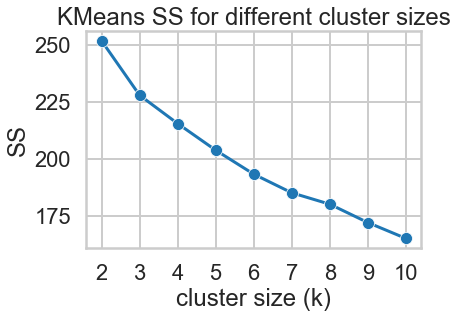

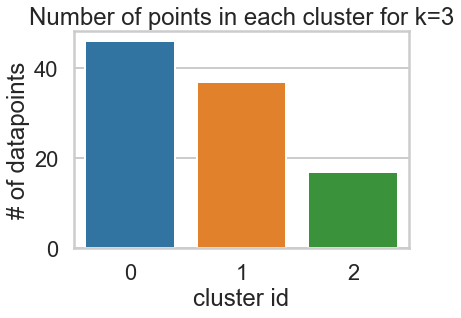

In [238]:
# your turn
from sklearn.cluster import KMeans


#create matrix of 0/1 columns
x_cols = np.array(df_01.loc[:,cols_01])
#set up variables
ks = range(2,11)
SS_values = []

#loop through k, constructing KMeans model and saving SS for each
for k in ks:
    model = KMeans(n_clusters=k, random_state=10)
    model.fit(x_cols)
    SS_values.append(model.inertia_)

#Draw elbow plot
_ = sns.lineplot(ks, SS_values, marker='o')
_ = plt.xticks(ks)
_ = plt.xlabel('cluster size (k)')
_ = plt.ylabel('SS')
_ = plt.title('KMeans SS for different cluster sizes')

#Draw bar graph for cluster sizes at k=3
model3 = KMeans(n_clusters=3, random_state=10)
df_01['labels'] = model3.fit_predict(x_cols)
label_counts = df_01['labels'].value_counts()
_ = plt.figure()
_ = sns.barplot(label_counts.index, label_counts.values)
_ = plt.xlabel('cluster id')
_ = plt.ylabel('# of datapoints')
_ = plt.title('Number of points in each cluster for k=3')

__The elbow method doesn't show a clear value for k; there is a slight eblow at k=3 when beginning with certain random seeds, but it is less prominent with others seeds. Nevertheless, I'll choose k=3 for the subsequent bargraph. The ambiguity suggests that another method may be better at estimating cluster size.__

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

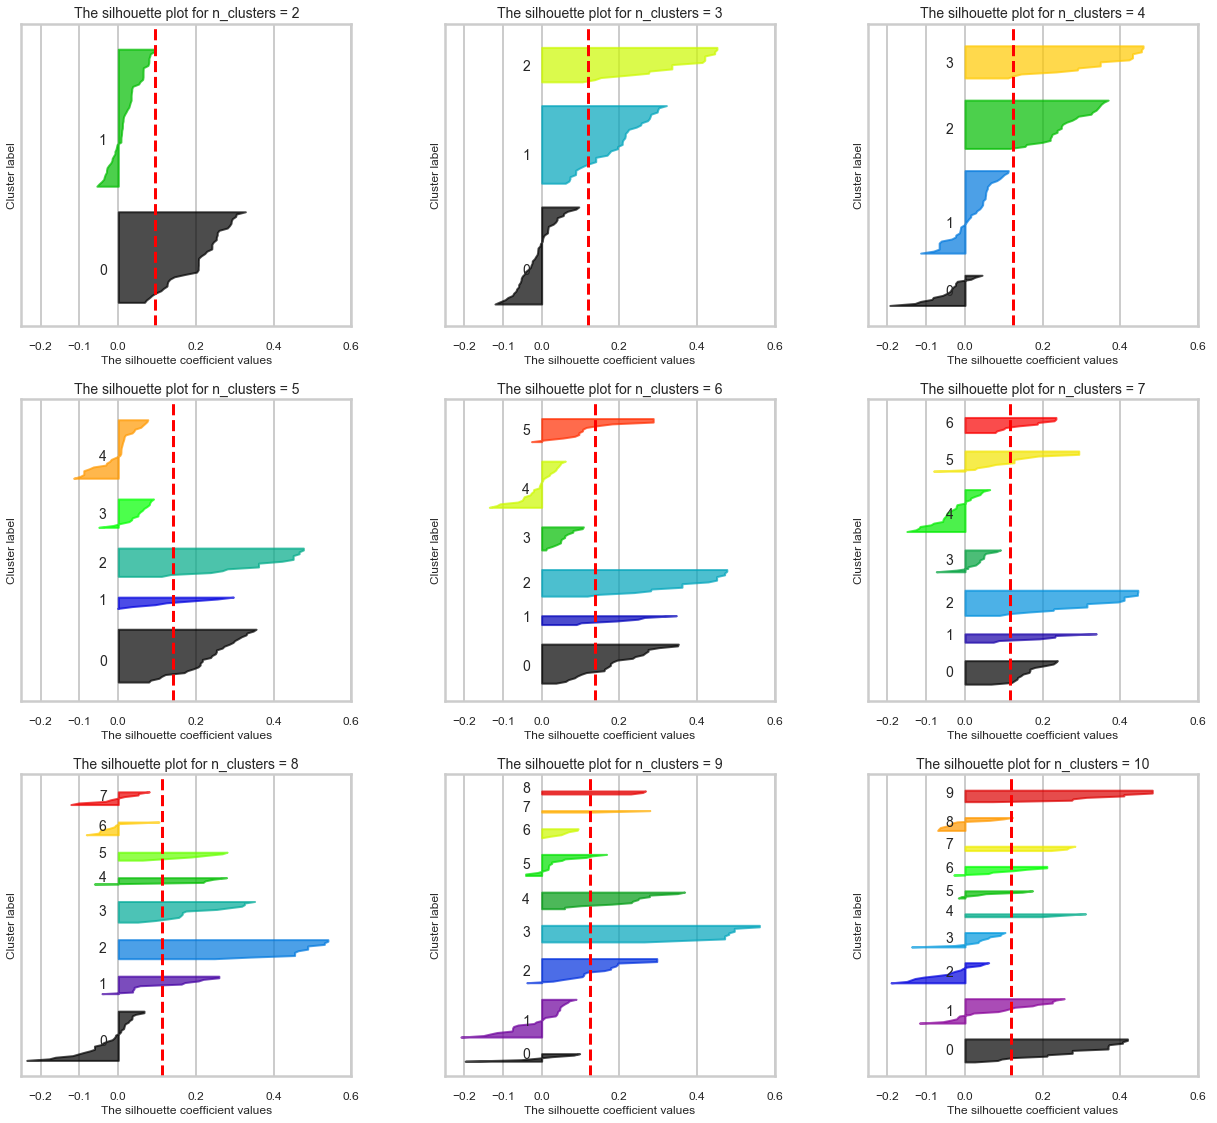

In [239]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = ks
all_silhouette_avgs = []

# Create subplots for 9 values of k (2 through 10) 
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9]] = plt.subplots(3, 3)
fig.set_size_inches(18, 16)
fig.tight_layout()
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
ax_count = 0
#Loop through each k, making silhouette plots 
for n_clusters in range_n_clusters:
    curax = ax_list[ax_count]
    curax.set_xlim([-.25, .6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    curax.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # Add the average silhouette score to the list
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    all_silhouette_avgs.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        curax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        curax.text(-0.05, y_lower + 0.3 * size_cluster_i, str(i), fontsize=14)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    curax.set_title("The silhouette plot for n_clusters = %d" % n_clusters, fontsize=14)
    curax.set_xlabel("The silhouette coefficient values", fontsize=12)
    curax.set_ylabel("Cluster label", fontsize=12)

    # The vertical line for average silhouette score of all the values
    curax.axvline(x=silhouette_avg, color="red", linestyle="--")

    curax.set_yticks([])  # Clear the yaxis labels / ticks
    curax.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6])
    curax.tick_params(axis='x', labelsize=12)
    curax.tick_params(axis='y', labelsize=14)
    ax_count += 1
    
plt.show()


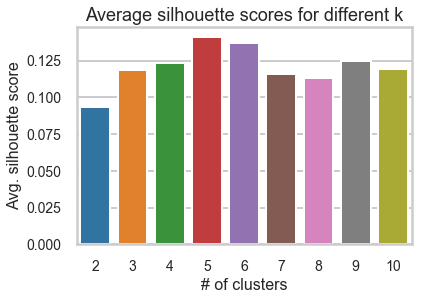

In [240]:
#Plot avg silhouette scores for each k
ax_bar = sns.barplot(list(range_n_clusters), all_silhouette_avgs)
ax_bar.set_title("Average silhouette scores for different k", fontsize = 18)
ax_bar.set_xlabel("# of clusters", fontsize=16)
ax_bar.set_ylabel("Avg. silhouette score", fontsize=16)
ax_bar.tick_params(labelsize=14)

__The average silhouette scores suggest that we should use 5 clusters (because this is the highest value indicating the most differentiated clusters), although 6 clusters is a close contender. This is different from the 3 clusters that was originally suggested by the elbow plot.__

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

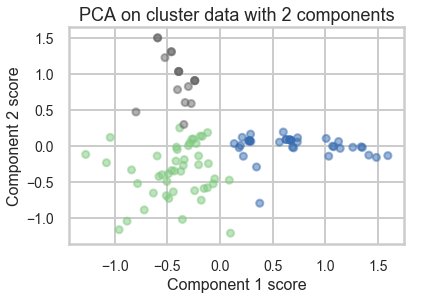

In [333]:
#Do PCA with 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
comp_scores = pca.fit_transform(x_cols)
#create dataframe with customer name, labels for k=3, and the two PCA components x, y
df_pca = pd.DataFrame({'customer_name': df_01['customer_name'], 'labels_k3': df_01['labels'],
                       'x': comp_scores[:,0], 'y': comp_scores[:,1]})

ax_s = plt.subplot()
_ = ax_s.scatter(df_pca.x, df_pca.y, c=df_pca.labels_k3, label=df_pca.labels_k3, cmap=cm.Accent, alpha=.5, s=50)
ax_s.set_title("PCA on cluster data with 2 components", fontsize = 18)
ax_s.set_xlabel("Component 1 score", fontsize=16)
ax_s.set_ylabel("Component 2 score", fontsize=16)
ax_s.tick_params(labelsize=14)

__The data above are colored according to the label they received during KMeans clustering with k=3. I used these labels because that was the best k suggested by the elbow plot. Interestingly, the PCA method could also be interpreted as 3 clusters, if you allow for thinner, elongated shapes in the black and blue clusters. The green cluster looks like it _could_ potentially be split into two (left and right), but it's too ambiguous. Visually, the PCA method might have returned the clearest evidence for 3 clusters. However, it should be remembered that this visual PCA approach only takes into account 2 dimensions and disregards the rest of the variance in the data, whereas the elbow plot and silhouette plots take into account all of the data. Thus, it's not clear that we should prioritize PCA over the other two approaches.__ 

In [265]:
#Merge datasets with cluster labels for exploring customer differences by group
df_all = pd.merge(df_transactions, df_pca)
df_all = pd.merge(df_offers, df_all)

#Construct booleans for each group for groupby comparisons
df_all['is_0'] = df_all['labels_k3']==0
df_all['is_1'] = df_all['labels_k3']==1
df_all['is_2'] = df_all['labels_k3']==2

#Group 0 comparison
print(df_all.groupby('is_0').varietal.value_counts())
print(df_all.groupby('is_0').min_qty.mean())
print(df_all.groupby('is_0').origin.value_counts())

#Group 1 comparison
print(df_all.groupby('is_1').varietal.value_counts())
print(df_all.groupby('is_1').min_qty.mean())
print(df_all.groupby('is_1').origin.value_counts())

#Group 2 comparison
print(df_all.groupby('is_2').varietal.value_counts())
print(df_all.groupby('is_2').min_qty.mean())
print(df_all.groupby('is_2').origin.value_counts())

is_0   varietal          
False  Pinot Noir            38
       Espumante             32
       Prosecco              22
       Malbec                20
       Pinot Grigio          16
       Merlot                 8
       Champagne              7
       Cabernet Sauvignon     2
       Chardonnay             2
True   Champagne             74
       Cabernet Sauvignon    30
       Prosecco              21
       Chardonnay            13
       Malbec                12
       Merlot                12
       Espumante              8
       Pinot Noir             6
       Pinot Grigio           1
Name: varietal, dtype: int64
is_0
False    31.836735
True     80.474576
Name: min_qty, dtype: float64
is_0   origin      
False  France          46
       Australia       30
       South Africa    18
       Oregon          16
       Italy           12
       Chile            8
       Germany          8
       California       7
       New Zealand      2
True   France          82
       Chile    

__By examining the groupby statements, we can derive general characteristics for each of our three groups separately. The wine features that appear to most distinguish the three groups are variety, minimum quantity, and origin.__

__Group 0:__ Group 0 has a strong affinity for both Champagne and Cabernet Sauvignon, together accounting for over 2/3 of sales in this group. These two wines are sold at very low numbers in the other groups. Group 0 also prefers buying in bulk quantities that are more than double those of the other groups. They also tend to buy a higher percentage of wines from France which may be a result of their different varietal preferences.

__Group 1:__ Compared to the other two groups, Group 1 buys a large percentage of Espumante and no Pinot Noir (a relative favorite among the other groups). They also respond to offers with small minimum quantities (16 vs. 77 for other groups). There preferred origin doesn't appear to differ much from the average of the others, with France being the primary country of origin.

__Group 2:__ Group 2 buys almost exclusively Pinot Noir (38 out of 45 orders), whereas this variety is rarely chosen by the other two groups. Though the minimum quantity of their typical order does not differ much from the others (65 vs. 57), they prefer most of their wines from Australia or Italy, whereas others have a strong preference for France.



What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

2.8474747474747484


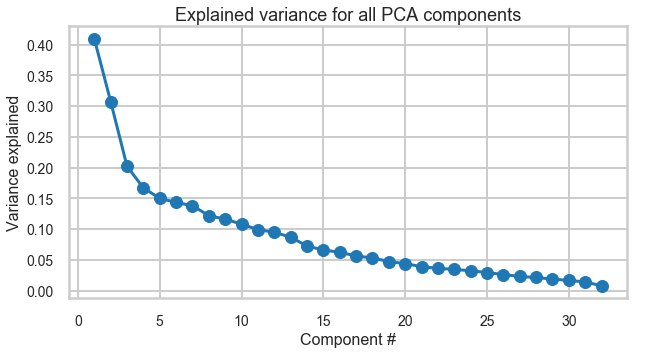

In [287]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Plot explained variance for each component
fig, ax_ev = plt.subplots()
fig.set_size_inches(10, 5)
ax_ev.plot(list(range(1, pca.n_components_ + 1)), pca.explained_variance_, marker='o',)
ax_ev.set_title("Explained variance for all PCA components", fontsize = 18)
ax_ev.set_xlabel("Component #", fontsize=16)
ax_ev.set_ylabel("Variance explained", fontsize=16)
ax_ev.tick_params(labelsize=14)
print(sum(pca.explained_variance_))

__In the scree plot above, the rate of variance being explained starts to significantly drop between the 3rd and 4th components, suggesting that we might be justified in choosing 3 components.__

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


Number of clusters using Affinity Propagation: 14


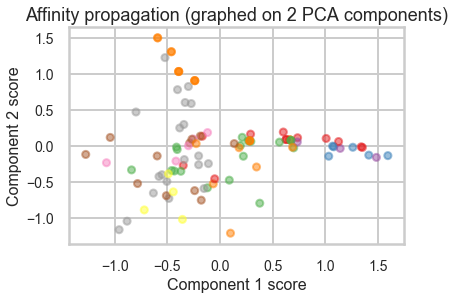

In [410]:
# Affinity propagation
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation(damping=.7)
df_pca['labels_affprop'] = ap.fit_predict(x_cols)

ax_ap = plt.subplot()
_ = ax_ap.scatter(df_pca.x, df_pca.y, c=df_pca.labels_affprop, cmap=cm.Set1, alpha=.5, s=50)
ax_ap.set_title("Affinity propagation (graphed on 2 PCA components)", fontsize = 18)
ax_ap.set_xlabel("Component 1 score", fontsize=16)
ax_ap.set_ylabel("Component 2 score", fontsize=16)
ax_ap.tick_params(labelsize=14)
print("Number of clusters using Affinity Propagation: {}".format(len(np.unique(ap.labels_))))

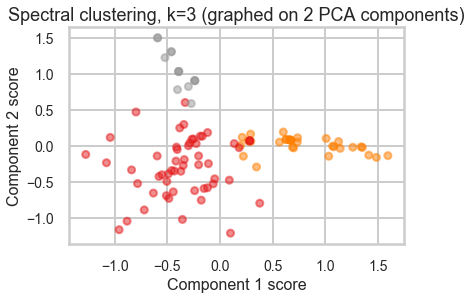

In [335]:
# Spectral clustering with n_clusters=3
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3)
df_pca['labels_specclust'] = sc.fit_predict(x_cols)

ax_sc = plt.subplot()
_ = ax_sc.scatter(df_pca.x, df_pca.y, c=df_pca.labels_specclust, cmap=cm.Set1, alpha=.5, s=50)
ax_sc.set_title("Spectral clustering, k=3 (graphed on 2 PCA components)", fontsize = 18)
ax_sc.set_xlabel("Component 1 score", fontsize=16)
ax_sc.set_ylabel("Component 2 score", fontsize=16)
ax_sc.tick_params(labelsize=14)

Text(0.5, 0, 'customer (leaves)')

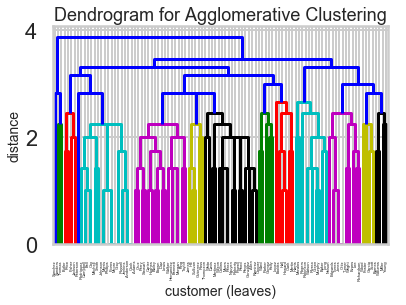

In [416]:
#Agglomerative Clustering (using linkage in scipy)
from scipy.cluster.hierarchy import dendrogram, linkage
mergings = linkage(x_cols, method='complete')

dendrogram(mergings, labels=list(df_01['customer_name']), leaf_rotation=90, leaf_font_size=4)
plt.title("Dendrogram for Agglomerative Clustering", fontsize=18)
plt.ylabel("distance", fontsize=14)
plt.xlabel("customer (leaves)", fontsize=14)


Number of clusters using DBSCAN with eps=1: 4
Number of noisy (unclustered) points (in RED): 51 (51.0%)


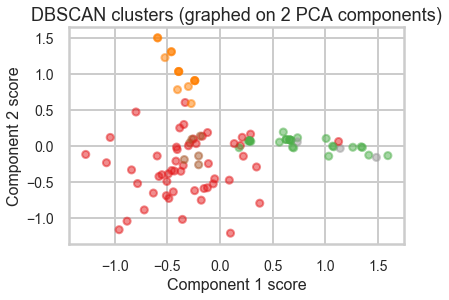

In [405]:
#DBSCAN
from sklearn.cluster import DBSCAN
#Best values for eps and min_samples
eps = 1
min_samples = 3
db = DBSCAN(eps=eps, min_samples=3).fit(x_cols)
df_pca['labels_dbscan'] = db.labels_

ax_db = plt.subplot()
_ = ax_db.scatter(df_pca.x, df_pca.y, c=df_pca.labels_dbscan, cmap=cm.Set1, alpha=.5, s=50)
ax_db.set_title("DBSCAN clusters (graphed on 2 PCA components)", fontsize = 18)
ax_db.set_xlabel("Component 1 score", fontsize=16)
ax_db.set_ylabel("Component 2 score", fontsize=16)
ax_db.tick_params(labelsize=14)

print("Number of clusters using DBSCAN with eps={}: {}".format(eps, len(np.unique(db.labels_[db.labels_>=0]))))
print("Number of noisy (unclustered) points (in RED): {} ({}%)".format(sum(db.labels_==-1), sum(db.labels_==-1)*100/x_cols.shape[0]))

__The four methods above returned a wide variety of results with different suggestions for clustering. First, the spectral clustering method requires that you specify the number of clusters in advance, so I chose 3 and plotted it against the first 2 PCA components as we've done previously. The results look very similar to the clustering results for previous methods, so I'll set this result aside for now.__

__The DBSCAN method returned results that are not quite as useful or clear. Despite tuning of the epsilon and min_points parameters, fully 50% of the data remained unclassified (i.e. considered noise, shown in red). Among the classified points, the algorithm settled on 4 clusters, shown in the graph above.__ 

__For the agglomerative clustering approach, I've plotted a dendrogram -- the colors were generated using the default threshold, but they appear to do a decent job of identifying places in the tree that might be distinct clusters. Splitting into 3 clusters doesn't seem to be strongly supported by the hierarchical diagram. Rather, there is evidence of around 12 smaller clusters of more uniform size.__ 

__Interestingly, the affinity propagation method returned 14 separate clusters, much more than we deduced from previous graphs and similar to the hierarchical approach. When plotted against the 2 PCA components, these clusters exhibit overlap and aren't visually distinct. However, this is likely due to the fact that the clusters are being partitioned by variance along the other 30 components that we can't see. It would therefore be premature to dismiss this classification out of hand.__

__Overall, we appear to be stuck between considering a small number of clusters (3 or 4), and a large number of clusters (12 to 14). One way to solve this problem would be to collect more data on more customers; 100 samples is fairly low. If there are truly 14 clusters, we will need many more samples within each cluster to verify this classificaiton. If, however, these additional clusters are just picking up on noise in the data, more samples will also bear this out and reinforce a 3 or 4 cluster structure.__